In [12]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from tqdm import tqdm

In [13]:
def special_fill_nan(df:pd.DataFrame):
    columns = [column for column in df.columns if (column !='id' and column != 'Personality')]

    for col in columns:
        if df[col].dropna().isin(["Yes", "No"]).all(): # Converts "Yes" and "No" columns to numerical booleans
            df[col] = df[col].map({"Yes": 1, "No": 0})
            
    
    df_dict = df.to_dict(orient="records")

    for i in tqdm(range(len(df_dict))):
        nan_columns = [k for k, v in df_dict[i].items() if pd.isna(v)]
        base_columns = [k for k, v in df_dict[i].items() if (not pd.isna(v) and k!='id' and k != 'Personality')]

        for nan_column in nan_columns: # For every empty column in a row
            accumulate = 0
            for base_column in base_columns: # Takes the value of every non-empty column, filters by it and takes the mode of the empty column, then takes the mean
                mode = df.query(f"{base_column} == {df_dict[i][base_column]}")[nan_column].mode()[0]

                accumulate += mode

            mean = round(accumulate/len(base_columns))

            df_dict[i][nan_column] = int(mean)

    
    new_df = pd.DataFrame(df_dict)
    new_df[columns] = new_df[columns].astype(int)

    return new_df


def standard_fill_nan(df:pd.DataFrame, strategy="mode"):
    columns = [column for column in df.columns if (column !='id' and column != 'Personality')]

    for col in columns:
        if df[col].dropna().isin(["Yes", "No"]).all(): # Converts "Yes" and "No" columns to numerical booleans
            df[col] = df[col].map({"Yes": 1, "No": 0})

        if strategy == "mode":    
            mode = df[col].mode()[0]
            fill_value = round(mode)
        elif strategy == "mean":
            mean = df[col].mean()
            fill_value = round(mean)

        df[col] = df[col].fillna(fill_value).round().astype(int)

    return df

def preprocess(df:pd.DataFrame, strategy="mode"):
    if strategy == "mean" or strategy=="mode":
        return standard_fill_nan(df, strategy)
    elif strategy == "special":
        return special_fill_nan(df)

In [14]:
original_df = pd.read_csv("data/train.csv")
original_df['label'] = [1 if x == 'Extrovert' else 0 for x in original_df['Personality']]
original_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,label
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,1
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,1
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert,0
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert,1
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert,1


In [15]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
 9   label                      18524 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 1.4+ MB


In [16]:
def cut_dataframe(data: pd.DataFrame, drop_columns: list[str]) -> pd.DataFrame:
    return data.drop(columns=drop_columns)

def split_data(data: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    x = data.drop(columns=['label'])
    y = data['label']

    return train_test_split(x, y, test_size=test_size, random_state=seed)

def test_random_forest(model: RandomForestClassifier, x_test, y_test):
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

def measure_method(
        data: pd.DataFrame, 
        strategy: str,
        n_estimators: int = 100, 
        seed: int = 42, 
        smote: bool = False
    ):
    
    processed_data = preprocess(data, strategy)
    x = processed_data.drop(columns=['label'])
    y = processed_data['label']

    if smote:
        model = Pipeline([
            ('smote', SMOTE(random_state=seed)),
            ('rf', RandomForestClassifier(n_estimators=n_estimators, random_state=seed))
        ])
    else:
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)


    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    scores = cross_validate(model, x, y, cv=kf, scoring=['f1', 'accuracy'], return_train_score=False)
    pr_scores = cross_val_predict(model, x, y, cv=kf, method='predict_proba')[:, 1]
    precision, recall, _ = precision_recall_curve(y, pr_scores)

    return scores, precision, recall

## Dataset com Drained_after_socializing

In [17]:
df = cut_dataframe(original_df, ['id', 'Personality'])
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,label
0,0.0,No,6.0,4.0,No,15.0,5.0,1
1,1.0,No,7.0,3.0,No,10.0,8.0,1
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,0
3,3.0,No,7.0,3.0,No,11.0,5.0,1
4,1.0,No,4.0,4.0,No,13.0,NaN,1


### Mode Fill

In [18]:
scores, precision, recall = measure_method(df.copy(), strategy='mode')

In [19]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.9622651953025944
f1: 0.974487967479505


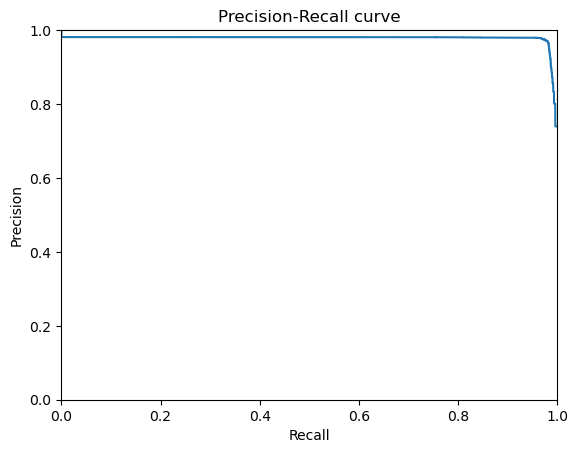

In [20]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

### Mean Fill

In [21]:
scores, precision, recall = measure_method(df.copy(), strategy='mean')

In [22]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.9648564195835994
f1: 0.9762230983175698


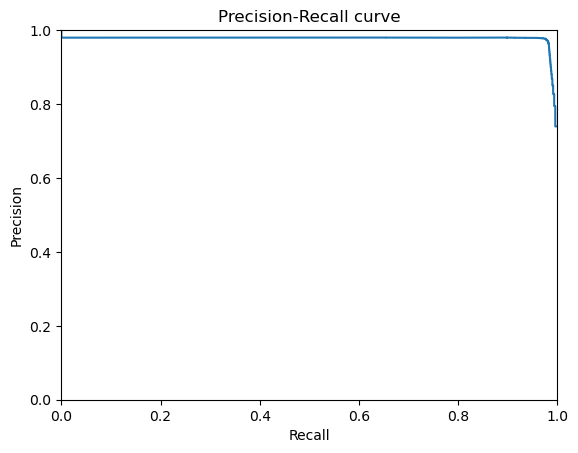

In [23]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

### Special Fill

In [24]:
scores, precision, recall = measure_method(df.copy(), strategy='special')

100%|██████████| 18524/18524 [04:04<00:00, 75.68it/s] 


In [25]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.961887254687641
f1: 0.9742877922682363


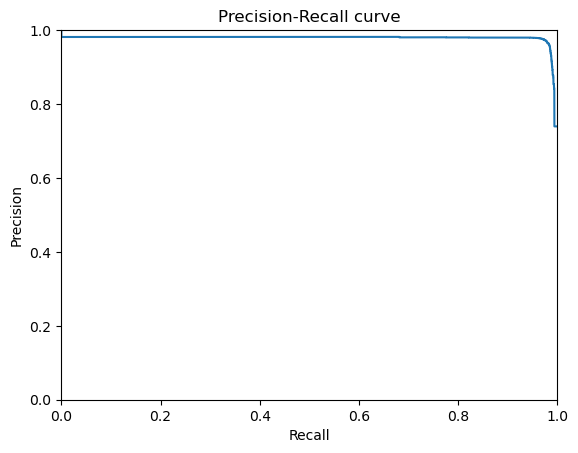

In [26]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

## Dataset sem Drained_after_socializing

In [27]:
df_cut = cut_dataframe(df, ['Drained_after_socializing'])

In [28]:
df_cut.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,label
0,0.0,No,6.0,4.0,15.0,5.0,1
1,1.0,No,7.0,3.0,10.0,8.0,1
2,6.0,Yes,1.0,0.0,3.0,0.0,0
3,3.0,No,7.0,3.0,11.0,5.0,1
4,1.0,No,4.0,4.0,13.0,NaN,1


### Mode Fill

In [29]:
scores, precision, recall = measure_method(df_cut.copy(), strategy='mode')

In [30]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.9611315483425293
f1: 0.9737378762605923


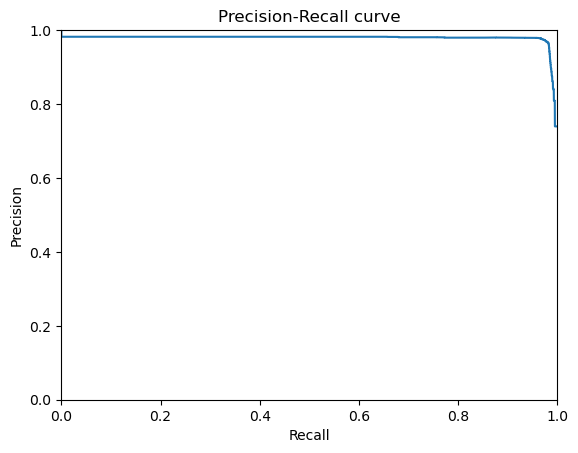

In [31]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

### Mean Fill

In [32]:
scores, precision, recall = measure_method(df_cut.copy(), strategy='mean')

In [33]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.9635068773445491
f1: 0.9753300309263111


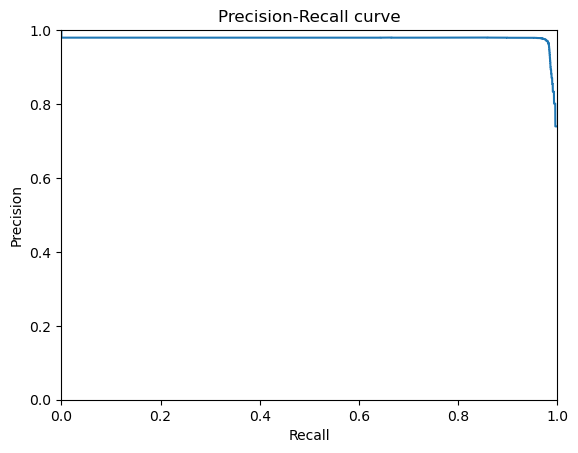

In [34]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

### Special Fill

In [35]:
scores, precision, recall = measure_method(df_cut.copy(), strategy='special')

100%|██████████| 18524/18524 [02:37<00:00, 117.97it/s]


In [36]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.9623190743930771
f1: 0.9745716644382343


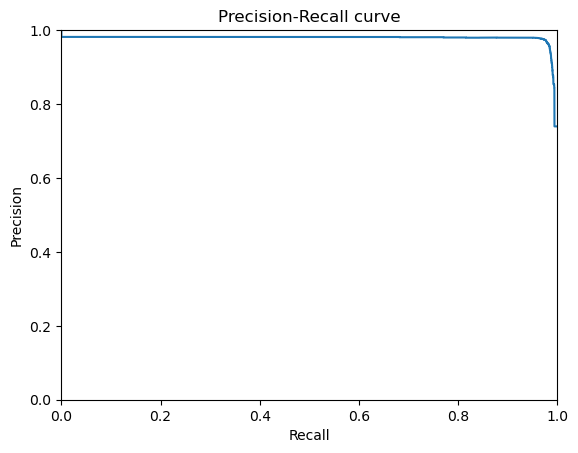

In [37]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

## Treino com SMOTE

### Mode Fill

In [38]:
scores, precision, recall = measure_method(df_cut.copy(), strategy='mode', smote=True)

In [39]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.9508745551368036
f1: 0.9665149133002894


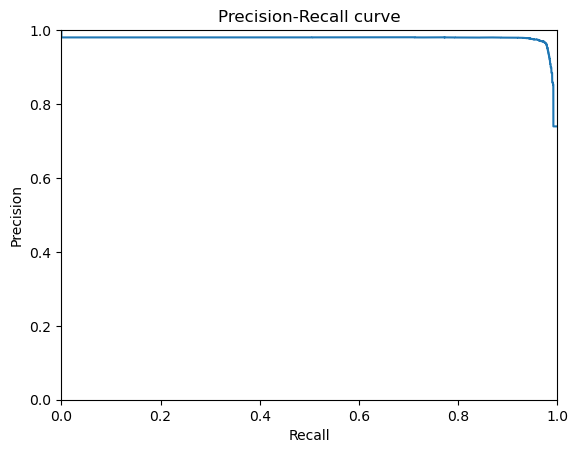

In [40]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

### Mean Fill

In [41]:
scores, precision, recall = measure_method(df_cut.copy(), strategy='mean', smote=True)

In [42]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.9515225324484161
f1: 0.9669282188209058


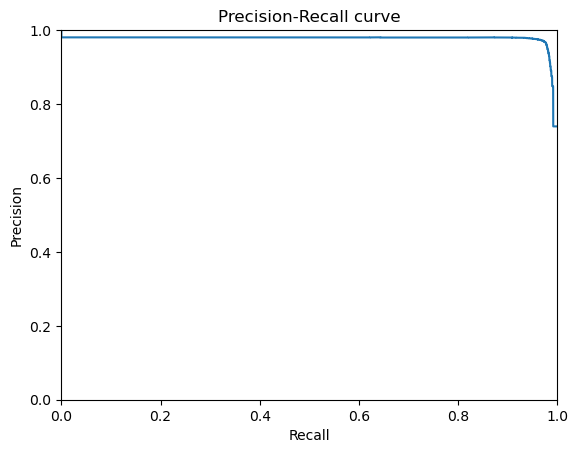

In [43]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

### Special Fill

In [44]:
scores, precision, recall = measure_method(df_cut.copy(), strategy='special', smote=True)

100%|██████████| 18524/18524 [02:52<00:00, 107.11it/s]


In [45]:
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

accuracy: 0.9513063165473078
f1: 0.9668475641838418


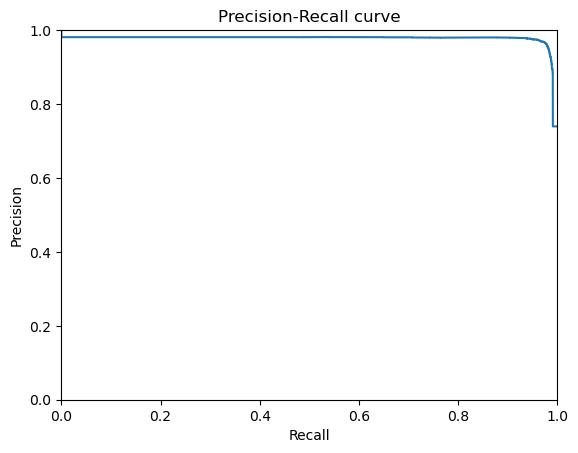

In [46]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

## Treina o modelo e gera o CSV

In [47]:
df_train = cut_dataframe(original_df, ['id', 'Personality', 'Drained_after_socializing'])
df_train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,label
0,0.0,No,6.0,4.0,15.0,5.0,1
1,1.0,No,7.0,3.0,10.0,8.0,1
2,6.0,Yes,1.0,0.0,3.0,0.0,0
3,3.0,No,7.0,3.0,11.0,5.0,1
4,1.0,No,4.0,4.0,13.0,NaN,1


In [ ]:
x = df_train.drop(columns=['label'])
y = df_train['label']
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x, y)

In [ ]:
test_df = pd.read_csv('data/test.csv')
predictions = model.predict(test_df)

In [ ]:
sample_submission = pd.read_csv('data/sample_submission.csv')

submission = sample_submission.copy()
submission["label"] = predictions

submission.to_csv("submission.csv", index=False)